In [1]:
#data manipulation
from pathlib import Path
import numpy as np
from numpy import percentile
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import glob
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.stats import gaussian_kde

from math import sqrt
import scipy.stats

#double iteration in pandas
from itertools import product

#compute distance between two points on earth
from haversine import haversine, haversine_vector, Unit

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import gdal

#colorbars
import cmocean
import cmaps

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
import matplotlib.patches as patches
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
import seaborn as seabornInstance 
from windrose import WindroseAxes
import seaborn as sns; sns.set(color_codes=True)
from matplotlib import style
style.use('fivethirtyeight')

%matplotlib inline

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:29: MatplotlibDeprecationWarning: 
The Appender class was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  addendum = docstring.Appender(msg, "\n\n")
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The copy_dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use docstring.copy() and cbook.dedent() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.getdoc() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in

In [2]:
# make a parser to include minutes, hours, days, months, years in one column and convert to datetime
def parse(yr, mo, doy, hr, min):
    yr, mo, doy, hr, min = [int(x) for x in [yr, mo, doy, hr, min]]
    dt = datetime(yr - 0, mo, doy, hr, min)
    return dt

# Buoy 44017

In [84]:
#read all files for the 44017 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44017'
all_files = glob.glob(path + "/*.txt")

b44017_wave_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44017_wave_wind = b44017_wave_wind[(b44017_wave_wind.WVHT !=99) & (b44017_wave_wind.WVHT > 0.1) &  (b44017_wave_wind.WSPD > 0.1) &
                                    (b44017_wave_wind.WSPD !=99)]
b44017_wave_wind['u10'] = b44017_wave_wind['WSPD']*np.sqrt((0.4**2)/0.0014)*(1/(np.log(4.1/0.000097)))
#b44017_wave_wind['u10'] = b44017_wave_wind['WSPD']*(10/4.1)**0.11
b44017_wave_wind

,Date,WSPD,WVHT,u10
0,2005-01-01 01:00:00,8.0,1.02,8.029038
1,2005-01-01 02:00:00,8.5,1.19,8.530853
2,2005-01-01 03:00:00,9.1,1.29,9.133031
3,2005-01-01 04:00:00,9.4,1.39,9.434119
4,2005-01-01 05:00:00,10.0,1.52,10.036297
...,...,...,...,...
3871,2020-05-31 19:40:00,4.6,0.77,4.616697
3877,2020-05-31 20:40:00,4.7,0.81,4.717060
3883,2020-05-31 21:40:00,6.9,0.79,6.925045
3889,2020-05-31 22:40:00,6.3,0.82,6.322867


In [85]:
x = b44017_wave_wind['u10']
y = b44017_wave_wind['WVHT']

In [86]:
model1 = LinearRegression(fit_intercept=False)

#model.fit(x[:, np.newaxis], y)
xfit = np.linspace(pd.Series.min(x), 25, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

In [87]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.94211103, -0.05074604,  0.01269756])

In [88]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

# R squared
print(np.mean(scores['test_r2']))

# RMSE mean
print(-np.mean(scores['test_neg_root_mean_squared_error']))

# RMSE std
print(np.std(scores['test_neg_root_mean_squared_error']))

0.4954225629775541
0.5340817241666415
0.043515621004970466


Text(0.5, 1.0, 'Buoy 44017')

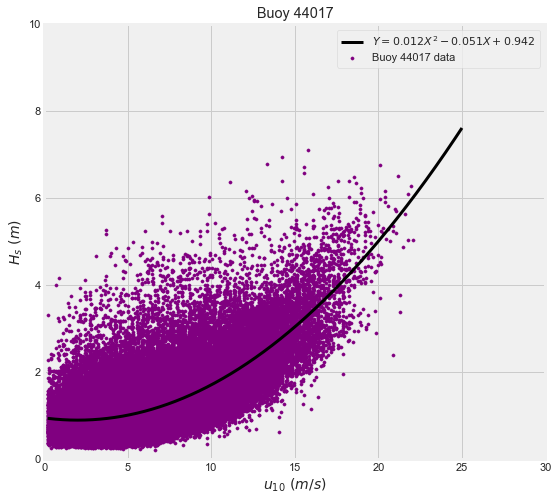

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=10,color='purple', label='Buoy 44017 data')

ax.plot(xfit, yfit, color='black', linewidth=3, label=r'$Y=0.012X^2 - 0.051X + 0.942$')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

plt.ylim(0,10)
plt.xlim(0,30)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')
#extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
#ax.legend([extra], [(r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_neg_root_mean_squared_error']),
                                                      #np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
plt.title('Buoy 44017')

# Buoy 44025

In [26]:
#read all files for the 44025 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44025'
all_files = glob.glob(path + "/*.txt")

b44025_wave_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44025_wave_wind = b44025_wave_wind[(b44025_wave_wind.WVHT !=99) & (b44025_wave_wind.WVHT > 0.1) &  (b44025_wave_wind.WSPD > 0.1) &
                                    (b44025_wave_wind.WSPD !=99)]
b44025_wave_wind['u10'] = b44025_wave_wind['WSPD']*np.sqrt((0.4**2)/0.0014)*(1/(np.log(4.1/0.000097)))
b44025_wave_wind

,Date,WSPD,WVHT,u10
0,2005-01-01 00:00:00,9.0,0.87,9.032668
1,2005-01-01 01:00:00,9.3,1.00,9.333757
2,2005-01-01 02:00:00,8.9,1.27,8.932305
3,2005-01-01 03:00:00,9.8,1.42,9.835571
4,2005-01-01 04:00:00,10.2,1.60,10.237023
...,...,...,...,...
3819,2020-05-31 19:40:00,1.5,0.71,1.505445
3825,2020-05-31 20:40:00,3.5,0.65,3.512704
3831,2020-05-31 21:40:00,1.6,0.61,1.605808
3837,2020-05-31 22:40:00,2.9,0.56,2.910526


In [27]:
x = b44025_wave_wind['u10']
y = b44025_wave_wind['WVHT']

In [28]:
model1 = LinearRegression(fit_intercept=False)

#model.fit(x[:, np.newaxis], y)
xfit1 = np.linspace(pd.Series.min(x), 25, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit1 = poly_model.predict(xfit[:, np.newaxis])

In [29]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.93097119, -0.04837117,  0.0121462 ])

In [30]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

# R squared
print(np.mean(scores['test_r2']))

# RMSE mean
print(-np.mean(scores['test_neg_root_mean_squared_error']))

# RMSE std
print(np.std(scores['test_neg_root_mean_squared_error']))

0.5069171801950012
0.5138371327159975
0.051356960132801


Text(0.5, 1.0, 'Buoy 44025')

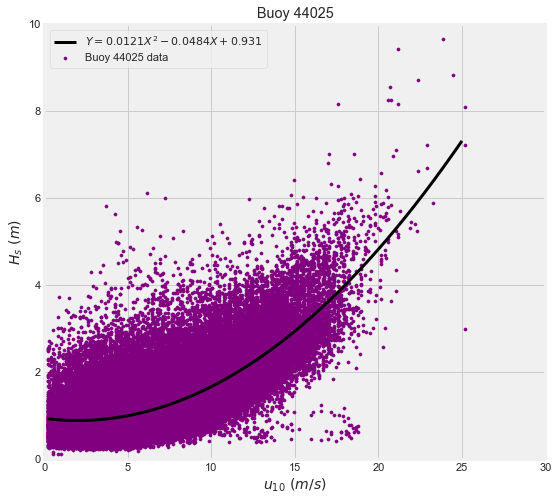

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=10,color='purple', label='Buoy 44025 data')

ax.plot(xfit1, yfit1, color='black', linewidth=3, label=r'$Y=0.0121X^2 - 0.0484X + 0.931 $')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

plt.ylim(0,10)
plt.xlim(0,30)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')
#extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
#ax.legend([extra], [(r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_neg_root_mean_squared_error']),
                                                      #np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
plt.title('Buoy 44025')

# Buoy 44065

In [32]:
#read all files for the 44065 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44065'
all_files = glob.glob(path + "/*.txt")

b44065_wave_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44065_wave_wind = b44065_wave_wind[(b44065_wave_wind.WVHT !=99) & (b44065_wave_wind.WVHT > 0.1) &  (b44065_wave_wind.WSPD > 0.1) &
                                    (b44065_wave_wind.WSPD !=99)]
b44065_wave_wind['u10'] = b44065_wave_wind['WSPD']*np.sqrt((0.4**2)/0.0014)*(1/(np.log(4.1/0.000097)))
b44065_wave_wind

,Date,WSPD,WVHT,u10
0,2008-10-30 17:50:00,8.2,0.67,8.229764
1,2008-10-30 18:50:00,8.3,0.54,8.330127
2,2008-10-30 19:50:00,7.1,0.56,7.125771
3,2008-10-30 20:50:00,8.1,0.61,8.129401
5,2008-10-30 22:50:00,7.9,0.61,7.928675
...,...,...,...,...
4397,2020-05-31 19:40:00,3.7,0.57,3.713430
4403,2020-05-31 20:40:00,5.7,0.56,5.720689
4409,2020-05-31 21:40:00,5.8,0.62,5.821052
4415,2020-05-31 22:40:00,6.5,0.69,6.523593


In [33]:
x = b44065_wave_wind['u10']
y = b44065_wave_wind['WVHT']

In [34]:
model1 = LinearRegression(fit_intercept=False)

#model.fit(x[:, np.newaxis], y)
xfit2 = np.linspace(pd.Series.min(x), 25, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit2 = poly_model.predict(xfit[:, np.newaxis])

In [35]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.83783175, -0.04567021,  0.00956735])

In [36]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

# R squared
print(np.mean(scores['test_r2']))

# RMSE mean
print(-np.mean(scores['test_neg_root_mean_squared_error']))

# RMSE std
print(np.std(scores['test_neg_root_mean_squared_error']))

0.36168317793560883
0.4456684077214926
0.04689755138791041


Text(0.5, 1.0, 'Buoy 44065')

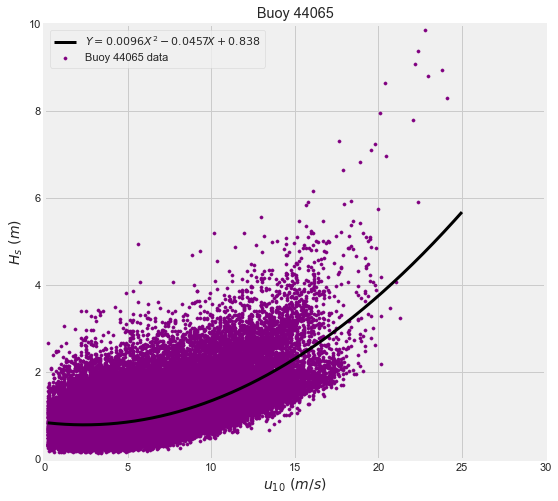

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=10,color='purple', label='Buoy 44065 data')

ax.plot(xfit2, yfit2, color='black', linewidth=3, label=r'$Y=0.0096X^2 - 0.0457X + 0.838 $')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

plt.ylim(0,10)
plt.xlim(0,30)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')
#extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
#ax.legend([extra], [(r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_neg_root_mean_squared_error']),
                                                      #np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
plt.title('Buoy 44065')

# Buoy 44020

In [38]:
#read all files for the 44020 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44020'
all_files = glob.glob(path + "/*.txt")

b44020_wave_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44020_wave_wind = b44020_wave_wind[(b44020_wave_wind.WVHT !=99) & (b44020_wave_wind.WVHT > 0.1) &  (b44020_wave_wind.WSPD > 0.1) &
                                    (b44020_wave_wind.WSPD !=99)]
b44020_wave_wind['u10'] = b44020_wave_wind['WSPD']*np.sqrt((0.4**2)/0.0014)*(1/(np.log(3.8/0.000095)))
b44020_wave_wind

,Date,WSPD,WVHT,u10
2,2009-03-10 15:50:00,2.5,0.61,2.522133
3,2009-03-10 16:50:00,2.6,0.68,2.623019
5,2009-03-10 18:50:00,3.9,0.52,3.934528
6,2009-03-10 19:50:00,4.5,0.44,4.539840
9,2009-03-10 22:50:00,5.2,0.37,5.246037
...,...,...,...,...
4051,2020-05-31 19:40:00,5.7,0.48,5.750464
4057,2020-05-31 20:40:00,5.5,0.41,5.548693
4063,2020-05-31 21:40:00,5.7,0.41,5.750464
4069,2020-05-31 22:40:00,6.0,0.42,6.053120


In [39]:
x = b44020_wave_wind['u10']
y = b44020_wave_wind['WVHT']

In [40]:
model1 = LinearRegression(fit_intercept=False)

#model.fit(x[:, np.newaxis], y)
xfit3 = np.linspace(pd.Series.min(x), 25, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit3 = poly_model.predict(xfit[:, np.newaxis])

In [41]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.25432501, -0.01640013,  0.00697511])

In [42]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

# R squared
print(np.mean(scores['test_r2']))

# RMSE mean
print(-np.mean(scores['test_neg_root_mean_squared_error']))

# RMSE std
print(np.std(scores['test_neg_root_mean_squared_error']))

0.8173786947140981
0.1397816971779127
0.008772466049754814


Text(0.5, 1.0, 'Buoy 44020')

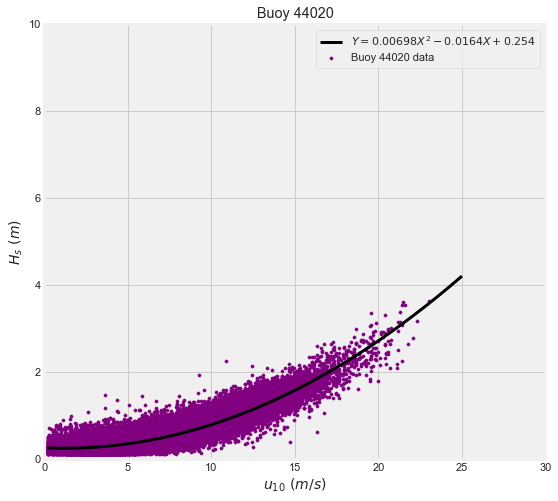

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=10,color='purple', label='Buoy 44020 data')

ax.plot(xfit3, yfit3, color='black', linewidth=3, label=r'$Y=0.00698X^2 - 0.0164X + 0.254 $')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

plt.ylim(0,10)
plt.xlim(0,30)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')
#extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
#ax.legend([extra], [(r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_neg_root_mean_squared_error']),
                                                      #np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
plt.title('Buoy 44020')

# Buoy 44039

In [44]:
#read all files for the 44039 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44039'
all_files = glob.glob(path + "/*.txt")

b44039_wave_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44039_wave_wind = b44039_wave_wind[(b44039_wave_wind.WVHT !=99) & (b44039_wave_wind.WVHT > 0.1) &  (b44039_wave_wind.WSPD > 0.1) &
                                    (b44039_wave_wind.WSPD !=99)]
b44039_wave_wind['u10'] = b44039_wave_wind['WSPD']*np.sqrt((0.4**2)/0.0014)*(1/(np.log(3.5/0.000097)))
b44039_wave_wind

,Date,WSPD,WVHT,u10
0,2005-01-01 00:00:00,6.2,0.5,6.316328
1,2005-01-01 02:00:00,7.7,0.6,7.844472
2,2005-01-01 03:00:00,6.7,0.6,6.825710
3,2005-01-01 04:00:00,6.7,0.6,6.825710
4,2005-01-01 05:00:00,4.6,0.5,4.686308
...,...,...,...,...
244,2019-02-04 04:30:00,2.1,0.2,2.139402
245,2019-02-04 04:45:00,1.5,0.2,1.528144
360,2019-02-05 20:00:00,1.0,0.2,1.018763
0,2019-06-28 13:23:00,3.6,0.2,3.667546


In [45]:
x = b44039_wave_wind['u10']
y = b44039_wave_wind['WVHT']

In [46]:
model1 = LinearRegression(fit_intercept=False)

#model.fit(x[:, np.newaxis], y)
xfit4 = np.linspace(pd.Series.min(x), 25, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit4 = poly_model.predict(xfit[:, np.newaxis])

In [47]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.19431655, -0.00239385,  0.00723   ])

In [48]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

# R squared
print(np.mean(scores['test_r2']))

# RMSE mean
print(-np.mean(scores['test_neg_root_mean_squared_error']))

# RMSE std
print(np.std(scores['test_neg_root_mean_squared_error']))

0.7613653785962243
0.17157397653934145
0.01658368941531863


Text(0.5, 1.0, 'Buoy 44039')

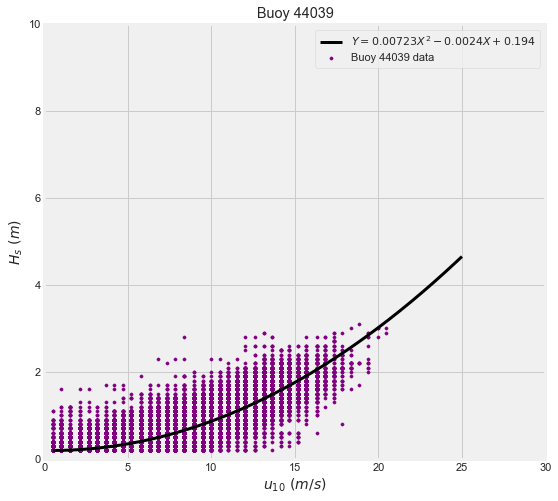

In [49]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=10,color='purple', label='Buoy 44039 data')

ax.plot(xfit4, yfit4, color='black', linewidth=3, label=r'$Y=0.00723X^2 - 0.0024X + 0.194 $')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

plt.ylim(0,10)
plt.xlim(0,30)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')
#extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
#ax.legend([extra], [(r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_neg_root_mean_squared_error']),
                                                      #np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
plt.title('Buoy 44039')

# Buoy 44040

In [50]:
#read all files for the 44040 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44040'
all_files = glob.glob(path + "/*.txt")

b44040_wave_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44040_wave_wind = b44040_wave_wind[(b44040_wave_wind.WVHT !=99) & (b44040_wave_wind.WVHT > 0.1) &  (b44040_wave_wind.WSPD > 0.1) &
                                    (b44040_wave_wind.WSPD !=99)]
b44040_wave_wind['u10'] = b44040_wave_wind['WSPD']*np.sqrt((0.4**2)/0.0014)*(1/(np.log(3.5/0.000097)))
b44040_wave_wind

,Date,WSPD,WVHT,u10
1,2006-05-01 00:30:00,4.6,0.2,4.686308
3,2006-05-01 01:30:00,3.1,0.2,3.158164
5,2006-05-01 02:30:00,2.1,0.2,2.139402
7,2006-05-01 03:30:00,1.5,0.2,1.528144
9,2006-05-01 04:30:00,1.5,0.2,1.528144
...,...,...,...,...
731,2020-05-31 16:45:00,3.6,0.4,3.667546
732,2020-05-31 17:30:00,4.1,0.4,4.176927
733,2020-05-31 18:45:00,4.1,0.4,4.176927
734,2020-05-31 19:00:00,3.6,0.4,3.667546


In [51]:
x = b44040_wave_wind['u10']
y = b44040_wave_wind['WVHT']

In [52]:
model1 = LinearRegression(fit_intercept=False)

#model.fit(x[:, np.newaxis], y)
xfit5 = np.linspace(pd.Series.min(x), 25, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit5 = poly_model.predict(xfit[:, np.newaxis])

In [53]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.27801205, -0.03776264,  0.00790831])

In [54]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

# R squared
print(np.mean(scores['test_r2']))

# RMSE mean
print(-np.mean(scores['test_neg_root_mean_squared_error']))

# RMSE std
print(np.std(scores['test_neg_root_mean_squared_error']))

0.5616030609248324
0.17743859019400887
0.012192684401931287


Text(0.5, 1.0, 'Buoy 44040')

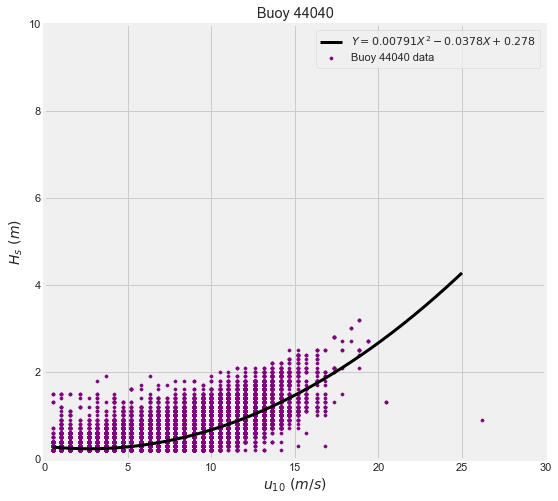

In [55]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=10,color='purple', label='Buoy 44040 data')

ax.plot(xfit5, yfit5, color='black', linewidth=3, label=r'$Y=0.00791X^2 - 0.0378X + 0.278 $')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

plt.ylim(0,10)
plt.xlim(0,30)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')
#extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
#ax.legend([extra], [(r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_neg_root_mean_squared_error']),
                                                      #np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
plt.title('Buoy 44040')

## Buoy Wind-Wave Relationships Comparison

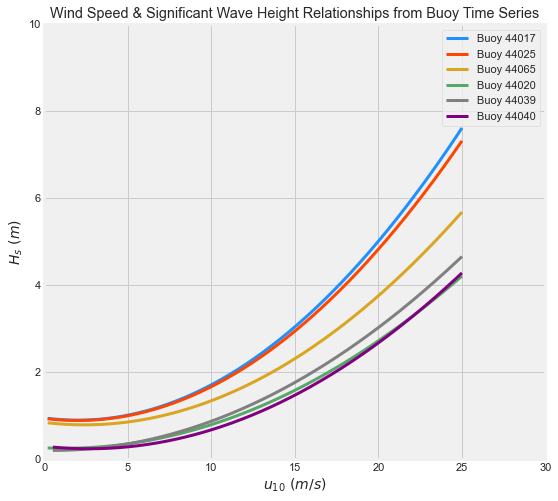

In [91]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(xfit, yfit, linewidth=3, color='dodgerblue', label='Buoy 44017')
ax.plot(xfit1, yfit1, linewidth=3, color='orangered', label='Buoy 44025')
ax.plot(xfit2, yfit2, linewidth=3, color='goldenrod', label='Buoy 44065')
ax.plot(xfit3, yfit3, linewidth=3, color='g', label='Buoy 44020')
ax.plot(xfit4, yfit4, linewidth=3, color='gray', label='Buoy 44039')
ax.plot(xfit5, yfit5, linewidth=3, color='purple', label='Buoy 44040')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

#ax.set(xlabel="$u_{10} \ (m/s)$", ylabel="Significant Wave Height (m)")
ax.legend(loc='best')

plt.xlim(0,30)
plt.ylim(0,10)

plt.title('Wind Speed & Significant Wave Height Relationships from Buoy Time Series')

plt.savefig('wind_wave_6buoys.png', dpi=300, bbox_inches='tight')

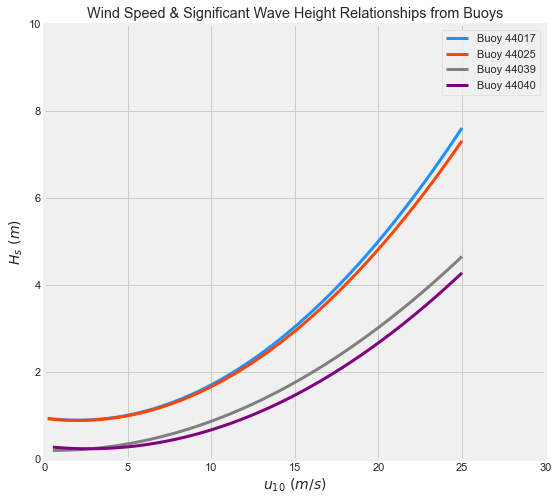

In [89]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(xfit, yfit, linewidth=3, color='dodgerblue', label='Buoy 44017')
ax.plot(xfit1, yfit1, linewidth=3, color='orangered', label='Buoy 44025')
#ax.plot(xfit2, yfit2, linewidth=3, color='goldenrod', label='Buoy 44065')
#ax.plot(xfit3, yfit3, linewidth=3, color='g', label='Buoy 44020')
ax.plot(xfit4, yfit4, linewidth=3, color='gray', label='Buoy 44039')
ax.plot(xfit5, yfit5, linewidth=3, color='purple', label='Buoy 44040')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

#ax.set(xlabel="$u_{10} \ (m/s)$", ylabel="Significant Wave Height (m)")
ax.legend(loc='best')

plt.xlim(0,30)
plt.ylim(0,10)

plt.title('Wind Speed & Significant Wave Height Relationships from Buoy Time Series')

plt.savefig('wind_wave_4buoys.png', dpi=300, bbox_inches='tight')

## Buoys Location

In [57]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15, 20),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlocator = mticker.FixedLocator([-74, -73, -72, -71, -70])
    gl.ylocator = mticker.FixedLocator([40, 41, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [58]:
buoys = pd.read_excel('buoys.xlsx', header=0, index_col=None, usecols="C:E")
for x,y,z in zip(buoys['Longitude'], buoys['Latitude'], buoys['Buoys']):print(x,y,z)

-71.127 40.969 44097
-70.279 41.493 44020
-73.164 40.251 44025
-72.049 40.693 44017
-73.703 40.369 44065
-72.655 41.138 44039
-73.58 40.956 44040
-71.033 41.397 BUZM3


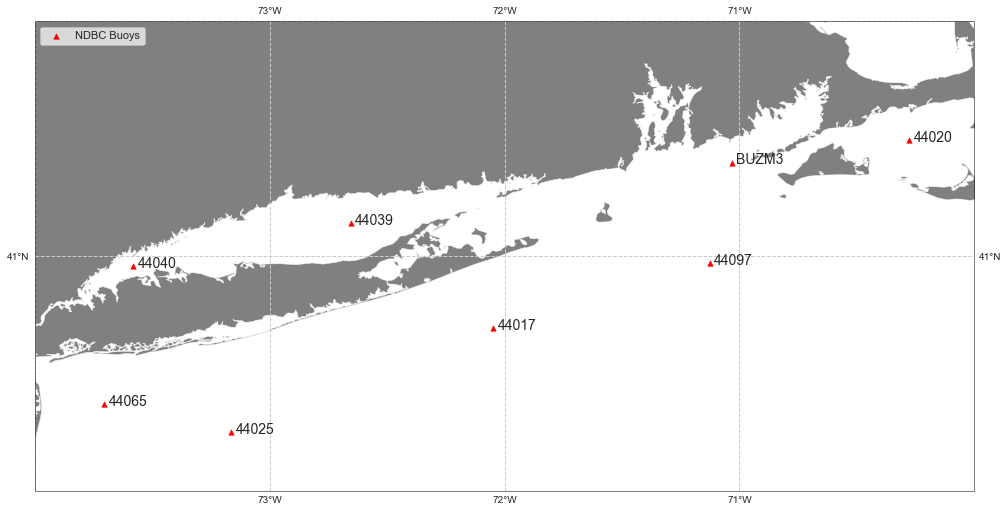

In [66]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

# Add markers for the position of the buoys.
plt.scatter(buoys['Longitude'], buoys['Latitude'], s=30, marker='^', color='red', label='NDBC Buoys',
            transform=ccrs.Geodetic())

for x,y,z in zip(buoys['Longitude'], buoys['Latitude'], buoys['Buoys']):
    ax.text(x+0.02, y+0.01, z,
                 verticalalignment='center', horizontalalignment='left', fontsize=14,
                 transform=ccrs.Geodetic())

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_h_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
     
ax.legend(loc='upper left')